In [1]:
%matplotlib inline

In [73]:
from IPython.display import display,SVG
from matplotlib import pyplot as plt
import numpy as np
from thllib import flylib
import figurefirst as fifi
import cv2

In [3]:
fly = flylib.NetFly(1331)
fly.open_signals('hdf5','txt')

opening hdf5


In [4]:
from thllib import util

In [78]:
light_on_thresh = 10 #threshold to use to find the begining of experiment. Average pixel value.
flash_offset = 50 #deal with the fact that the camera is over-exposed when the light first comes on
angles = np.linspace(0,360,360*2)[:-1] #resoluton of the angular tracking, larger values yeald slower tracking

In [81]:
def rotate_image(image, angle,center = None):
    row,col = image.shape
    if center is None:
        center=tuple(np.array([row,col])/2)
    rot_mat = cv2.getRotationMatrix2D(center,angle,1.0)
    new_image = cv2.warpAffine(image, rot_mat, (col,row),borderMode = cv2.BORDER_REPLICATE)
    return new_image

first_frame = fly.images[captured_frames[0]+flash_offset]

In [88]:
template_images = list()
for i in angles:
    template_images.append(rotate_image(first_frame,i,center = center))

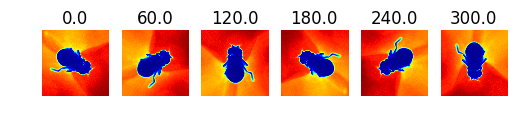

In [152]:
plt.subplot(1,6,1)
for i in range(6):
    plt.subplot(1,6,1+i)
    plt.imshow(template_images[i*120])
    plt.gca().axis('off')
    plt.gca().set_title(i*120/2.0)

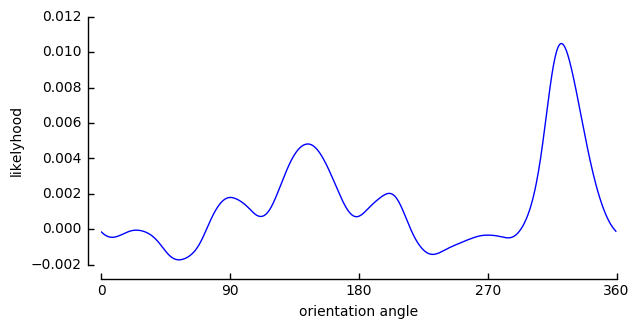

In [153]:
layout = fifi.FigureLayout('likelyhood_function_layout.svg',make_mplfigures=True)
layout.axes['likelyhood'].plot(angles,fly.correlations[1000]/np.sum(fly.correlations[1000]))
layout.apply_mpl_methods()
fifi.mpl_functions.set_spines(layout)

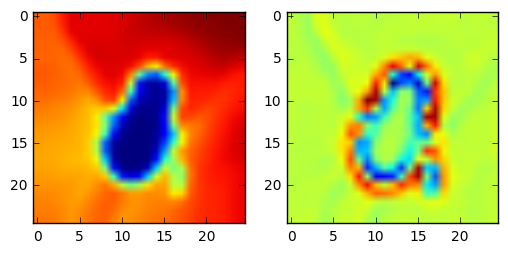

In [132]:
img = template_images[200]
gpyr = cv2.pyrDown(img)
for i in range(3):
    gpyr = cv2.pyrDown(gpyr)
lpyr = gpyr - cv2.pyrDown(cv2.pyrUp(gpyr))
plt.subplot(1,2,1)
plt.imshow(gpyr)
plt.subplot(1,2,2)
plt.imshow(lpyr)

In [5]:
angle_correction = -14 # degrees

In [201]:
likelyhood_pos = np.roll(fly.correlations,720/angle_correction,axis = 1)
likelyhood_pos = likelyhood_pos/np.sum(likelyhood_pos, axis = 1)[:,None]

In [202]:
angles = np.array(fly.angles)
positions = np.deg2rad(angles[np.argmax(likelyhood_pos,axis = 1)])
positions,velocity = util.rewrap(positions,offset = 0)

In [203]:
first_frame =  np.squeeze(np.argwhere(np.array(fly.avepxl)>10)[0]) + 1

#### Picking orientation as the best match to the template works most of the time, but there are some errors in the position estimate, as well as an occasional 180 degree flip in orientation.

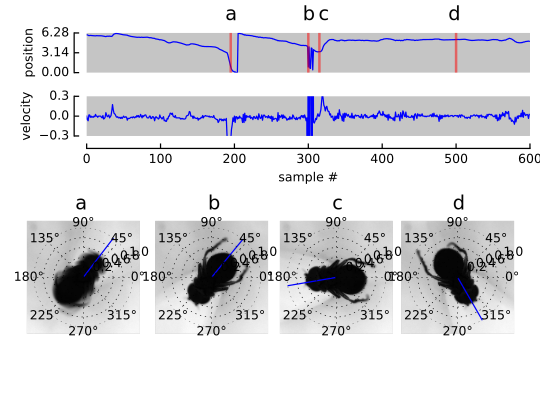

In [205]:
c_idx = 13526;
idx_1 = c_idx-105;
idx_2 = c_idx;
idx_3 = c_idx+15;
idx_4 = c_idx+200;

window = 300
layout = fifi.FigureLayout('evaluate_tracking_layout.svg',make_mplfigures = True)
layout.axes['position'].plot(positions[c_idx-window:c_idx+window])
layout.axes['velocity'].plot(velocity[c_idx-window:c_idx+window])
for i,imn,pnm in zip([idx_1,idx_2,idx_3,idx_4],
                     ['image1','image2','image3','image4'],
                     ['polar1','polar2','polar3','polar4']):
    layout.axes[imn].imshow(fly.images[i+first_frame-1],cmap = plt.cm.gray)
    layout.axes[imn].set_zorder(-10)
    layout.axes[pnm].plot([positions[i]]*2,[0,1])
    layout.axes['position'].axvline(window-(c_idx-i),color = 'r',lw = 2,alpha = 0.5)

layout.apply_mpl_methods()
fifi.mpl_functions.set_spines(layout)
layout.save('evaluate_tracking.svg');plt.close('all')
display(SVG('evaluate_tracking.svg'))

#### If I just look at the likelyhood function during one of these tracking errors it is hard to tell what angle to choose as the correct orientation of the fly, on the other hand, if I look at the time-history, it is clear what the correct choice should be.

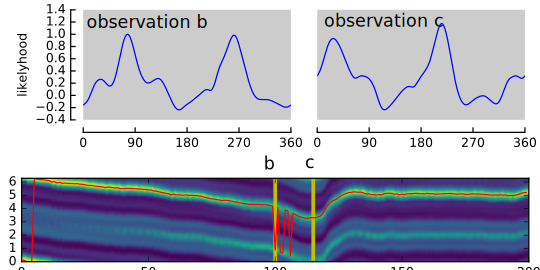

In [144]:
window = 100
layout = fifi.FigureLayout('likelyhood_inspection_layout.svg',make_mplfigures=True)
layout.axes['cor_image'].imshow(likelyhood[c_idx-window:c_idx+window][:,::-1].T,
           cmap = plt.cm.viridis,aspect = 'auto',
           extent = (0,window*2,0,2*np.pi))
layout.axes['cor_image'].axvline(window+(idx_2-c_idx),color = 'y',lw = 3)
layout.axes['cor_image'].axvline(window+(idx_3-c_idx),color = 'y',lw = 3)
layout.axes['cor_image'].plot(positions[c_idx-window:c_idx+window],color = 'r')
layout.axes['idx_2'].plot(angles,fly.correlations[idx_2]/
                            np.max(fly.correlations[idx_2]))
layout.axes['idx_3'].plot(angles,fly.correlations[idx_3]/
                              np.max(fly.correlations[idx_3]))
layout.apply_mpl_methods()
fifi.mpl_functions.set_spines(layout)
plt.close('all')
layout.save('likelyhood_inspection.svg');display(SVG('likelyhood_inspection.svg'))

#### To incorporate prior knowlege of the previous measurment I used a bayesian filter. The idea is to combine the current likelyhood function with the previous estimate of the state of the fly, to form a posterior likelyhood function for the current state. To do this I need to predict the prior probability distribution using the information I have on the fly's velocity and position and incorporating my uncertenty in these estimates. 

#### To estimate velocity I'll start with two likelyhood estimates in the above raster. I'm showing measurment 10 and 11 since it is  a little difficut to see in the first two.

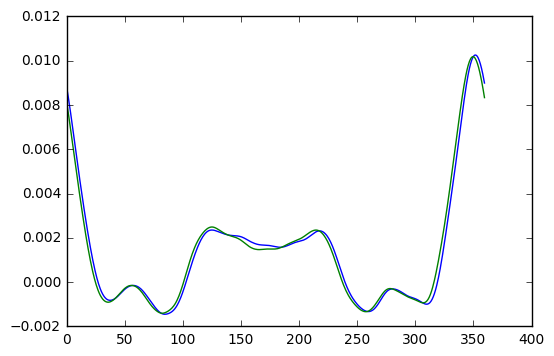

In [207]:
likelyhood_pos = likelyhood_pos[c_idx - 100:c_idx+100]
plt.plot(angles,likelyhood_pos[10])
plt.plot(angles,likelyhood_pos[11])

#### Looks like the second curve is shifted a little to the left of the first. To estimate the velocity I'll find the peak of the cross correlation.

estimated shift:2


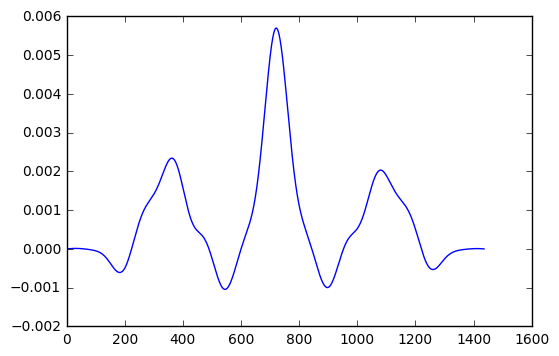

In [208]:
from scipy.signal import correlate
xrs_cor = correlate(likelyhood_pos[70],likelyhood_pos[71])
plt.plot(xrs_cor)
print('estimated shift:' + str(np.argmax(xrs_cor)-len(angles)))

#### One pixel to the left seems ok, so using this estimate of velocity I might form a prior for index 12 by simply shifting the likelyhood at index 11 the same amount.

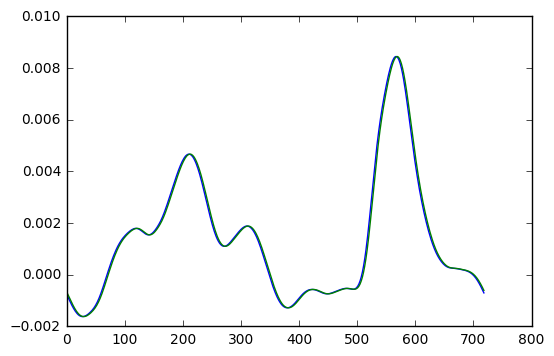

In [211]:
plt.plot(likelyhood_pos[70])
plt.plot(np.roll(likelyhood_pos[70], 2))

#### So, because the fly isn't moving very much, I dont expect the likelyhood to change much in the next frame. So perhaps I could make my prediction simply by shifting the current likelyhood function. However, this doesn't account for the added uncertanty that comes from the fact that I am making a prediction, and my estimate of velocity is not necessarily accurate. To incoporate measurement and prediction error into the posterior, I convovle the likelyhood functions with a von meises kernel. The degree of uncertanty is specified by the kappa paramenter.

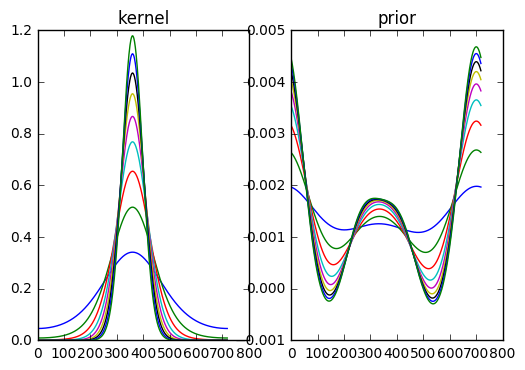

In [181]:
from scipy.stats import vonmises
from scipy.ndimage import convolve
kernels = [vonmises.pdf(np.deg2rad(angles),kapa,loc = np.pi) for kapa in range(1,10)]
ax1 = plt.subplot(1,2,1,title = 'kernel')
lns = [ax1.plot(k) for k in kernels]
ax2 = plt.subplot(1,2,2,title = 'prior')
for k in kernels:
    smth = convolve(s[11],k,mode = 'wrap')
    ax2.plot(smth/np.sum(smth))

#### Now I am ready to filter the data, but first I will create a vector of observed velocities.

In [19]:
velocities = []
for i in range(len(likelyhood_c)-1):
    velocities.append(np.argmax(correlate(likelyhood_c[i],likelyhood_c[i+1])))

#### The filter is recursive, so I march throught the data forming a posterior estimate of the fly orientation from my current best estimate of velocity, and position. 

In [177]:
prior = np.roll(convolve(s[11],kernels[5],mode = 'wrap'),velocities[11])
prior /= np.sum(prior)

In [178]:
posterior = prior*likelyhood[12]
posterior /= np.sum(posterior)

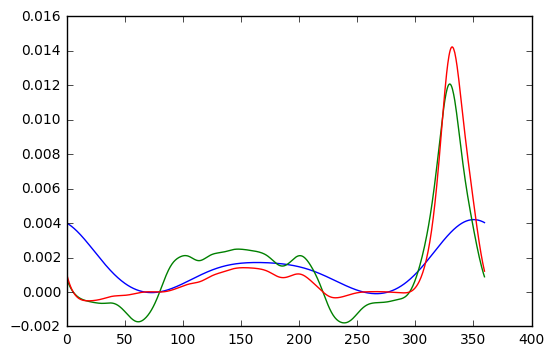

In [179]:
plt.plot(angles,prior)
plt.plot(angles,likelyhood[12])
plt.plot(angles,posterior)

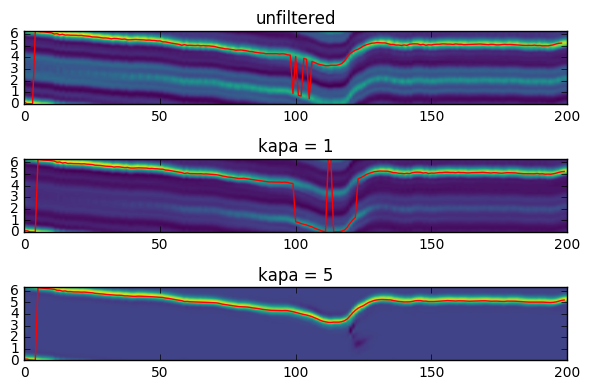

In [199]:
ax0 = plt.subplot(3,1,1,title = 'unfiltered')
ax0.imshow(np.array(likelyhood_c[1:])[:,::-1].T,
           aspect = 'auto',extent =(0,200,0,2*np.pi),
           cmap = plt.cm.viridis)
ax0.plot(np.deg2rad(angles[np.argmax(likelyhood_c[1:],axis = 1)]),
         color = 'r')
ax0.set_ybound(0,2*np.pi)
#########################################################
###### small kappa - trust the observation  #############
kernel = kernels[0] 
#########################################################
state_estimates = list()
state_estimates.append(likelyhood_c[0])
for observation,velocity in zip(likelyhood_c[1:],velocities):
    prediction = np.roll(state_estimates[-1],velocity)
    prediction = convolve(prediction,kernel,mode = 'wrap')
    prediction /= np.sum(prediction)
    #Calculate the posterior by multiplying the
    #two distributions together this is the baysian bit
    posterior = prediction*observation
    posterior /= np.sum(posterior)
    state_estimates.append(posterior)
ax1 = plt.subplot(3,1,2,title = 'kapa = 1')
filtered = np.deg2rad(angles[np.argmax(state_estimates,axis = 1)])
ax1.imshow(np.array(state_estimates[1:])[:,::-1].T,
           aspect = 'auto',extent =(0,200,0,2*np.pi),
           cmap = plt.cm.viridis)
ax1.plot(filtered,color = 'r')
ax1.set_ybound(0,2*np.pi)

#########################################################
###### large kappa - trust the prediciton  ##############
kernel = kernels[5] 
#########################################################
state_estimates = list()
state_estimates.append(likelyhood_c[0])
for observation,velocity in zip(likelyhood_c[1:],velocities):
    prediction = np.roll(state_estimates[-1],velocity)
    prediction = convolve(prediction,kernel,mode = 'wrap')
    prediction /= np.sum(prediction)
    #Calculate the posterior by multiplying the
    #two distributions together this is the baysian bit
    posterior = prediction*observation
    posterior /= np.sum(posterior)
    state_estimates.append(posterior)
ax2 = plt.subplot(3,1,3,title = 'kapa = 5')
filtered = np.deg2rad(angles[np.argmax(state_estimates,axis = 1)])
ax2.imshow(np.array(state_estimates[1:])[:,::-1].T,
           aspect = 'auto',extent =(0,200,0,2*np.pi),
           cmap = plt.cm.viridis)
ax2.plot(filtered,color = 'r')
ax2.set_ybound(0,2*np.pi)
plt.tight_layout()